# Description
### This notebook is designed to show uses of formal_tests.py, a script designed to present some robust information regarding the barotropic model. For example, understanding the required number of ensemble members to sample the forcing, and finding the zonally symmetric climatological variance caused by the forcing.

In [1]:
#import packages
%matplotlib notebook

import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path
from model.solver import Solver #bm3_barotropic_model packages
from model.sphere import Sphere
from model.forcing import Forcing

from utils import constants, plotting
import ensemble_methods as em

import time
import numpy as np
import random
import xarray as xr

import cartopy as crt             # Map projection stuff
import cartopy.crs as ccrs

import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    

from tqdm import tqdm



/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1.1) Do the basic properties of the model align with previous studies?

integrating for 41.7 days with a dt of 0.50 hours
output freq of 3.00 hours
integrating with:  nu= 1000000000000000.0 diffusion_order= 2


100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 233.91it/s]


<IPython.core.display.Javascript object>


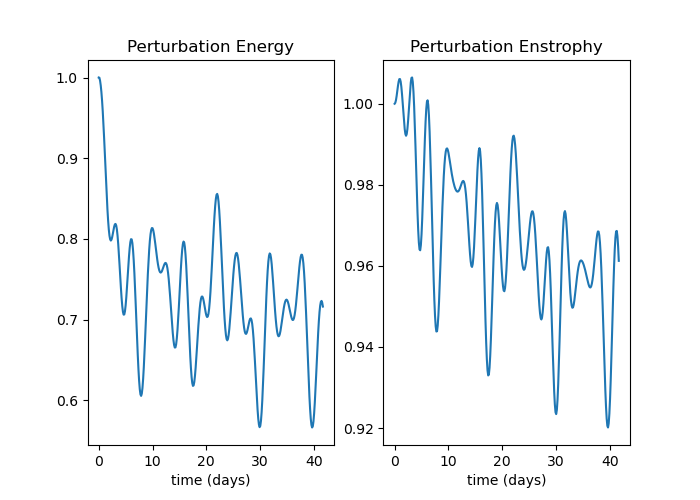

array([<AxesSubplot:title={'center':'Perturbation Energy'}, xlabel='time (days)'>,
       <AxesSubplot:title={'center':'Perturbation Enstrophy'}, xlabel='time (days)'>],
      dtype=object)

In [5]:
dt = 1800 #time between integration steps (seconds)
Nt = 2000 #number of integration steps

T= Nt*dt #total integration time
print('integrating for {:.1f} days with a dt of {:.2f} hours'.format(T*s2d,dt*s2h))

ofreq = 6 #frequency of integration output in resulting ds
print('output freq of {:.2f} hours'.format(dt*s2h*ofreq))

M = 63
st = Sphere(M, base_state='held85')

F = Forcing(st,dt,T)
forcing_tseries = F.generate_zeroforcing_tseries()

k0=3 #if we want to start with some structure in the vorticity here's an option
vortp = 1e-5 * np.exp( -0.5 * (st.glats - 45.)**2 / 10**2 ) * np.cos(k0 * st.rlons)

thetap = np.zeros(vortp.shape) #no temp perturbation
st.set_ics([vortp,thetap])

# Turn off frictional dissipation, thermal relaxation, add viscosity values from Held 1985
#params = dict(rs = 0., tau = 0., nu = 1e4, diffusion_order=1, robert_filter=0.01)

# Turn off frictional dissipation, add viscosity values from Held and Phillips 1987
params = dict(rs = 0., nu = 1e15, diffusion_order=2)

#choose whether we integrate with a linear temp/vorticity field. temp_linear=False uses nonlinear advection
S = Solver(st, forcing=F, ofreq=ofreq, **params)

sln = S.integrate_dynamics(temp_linear=True, vort_linear=False)

plotters.plot_energy(sln)
#plt.title('Held 1985 comparison')

## 2.1 Check how many members are needed to sample forcing well
Here we run just the red noise forcing out to 10 years to represent the climatological spread. Then, an ensemble of size e, of the forcing equation is generated for a single timestep. The variance of the ensemble represents the ability for an ensemble of size e to produce the climatological spread at any given time. This is repeated for a couple hundred runs to capture the spread of the estimated variance. Results for a single coordinate are plotted below; i've picked the a location that aligns with our stirring latitude. Small ensembles initially underestimate the climatological variance, but quickly asymptote to the climatology value. As the ensemble size increases, the spread in the estimated variance decreases as well. 200 seems like a pretty good number?

  0%|                                                 | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_39897/290532743.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  climatology[nm]=fmem.evolve_rededdy()
100%|███████████████████████████████████| 50000/50000 [00:40<00:00, 1238.44it/s]


<IPython.core.display.Javascript object>


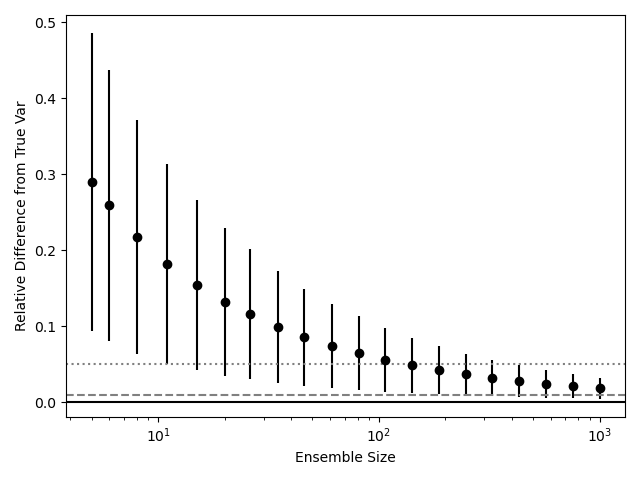

In [2]:
# generate an very large ensemble of forcings to create a pseudo-climatology
st= Sphere(base_state='solid')

clim_mem = 50000
climatology = np.empty((clim_mem, st.nspecindx))

for nm in tqdm(range(clim_mem)):
    fmem = Forcing(sphere=st)
    climatology[nm]=fmem.evolve_rededdy()

# Calculate the 'true' variance for each wavenumber in the ensemble
true_variance = climatology.std(axis=0)

# Define a range of ensemble sizes to test
ensemble_sizes = np.logspace( np.log10(5), np.log10(1000), 20).astype(int)
nruns = 100 #number of runs for each ensemble size

# Function to subsample and calculate variance
def subsample_variance(data, subsample_size, num_repeats):
    # generate an array of variances for each subsample
    return np.array([np.std(data[np.random.choice(data.shape[0], subsample_size, replace=True)], axis=0) for _ in range(num_repeats)])

ens_runs = np.empty((len(ensemble_sizes), nruns, st.nspecindx))
for ii, size in enumerate(ensemble_sizes):
    ens_runs[ii,:] = subsample_variance(climatology, size, num_repeats=nruns)

#For each ensemble size and each run,
#calculate mean absolute relative error of ensemble (sample) variance from true variance.
#Since there is a forcing on each wavenumber, use the sum of the MARE to characterize.
ens_mean_err    = np.mean(np.mean(np.abs(ens_runs - true_variance)/true_variance,axis=1), axis=1)
#Use the variance of the sample variance to plot error bars.
ens_mean_err_std= np.mean( np.std(np.abs(ens_runs - true_variance)/true_variance,axis=1), axis=1)

#We'll say that the ensemble becomes a good estimator of the 'true' variance when its mean dips below 5% error.
plt.figure()
plt.errorbar(ensemble_sizes, ens_mean_err, yerr=ens_mean_err_std, fmt='o', color = 'k')
    
plt.axhline(y=0., color='k', linestyle='-', label='True Variance')
plt.axhline(y=0.01, color='gray', linestyle='--')
plt.axhline(y=0.05, color='gray', linestyle=':')


plt.xlabel('Ensemble Size')
plt.ylabel(f'Relative Difference from True Var')
#plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.show()

## 2.2 Derive Climatological Spread
Run a single model for a long time (10 yrs) to what ensemble spread should be at very long lead times. Note that even for a very long simulation, there is some variance as a function of longitude in the climatology.

In [22]:
T = 2*365*constants.day2sec
dt= 1800

params=dict(nu=0., Kappa=0., tau = 1/8, diffusion_order=4, dt=dt, vort_linear=False, theta_linear=False)

st = Sphere(base_state='solid')
climatology = Solver(st, T= T, **params).integrate_dynamics(verbose=True)

100%|████████████████████████████████████| 35040/35040 [02:57<00:00, 197.21it/s]


<IPython.core.display.Javascript object>


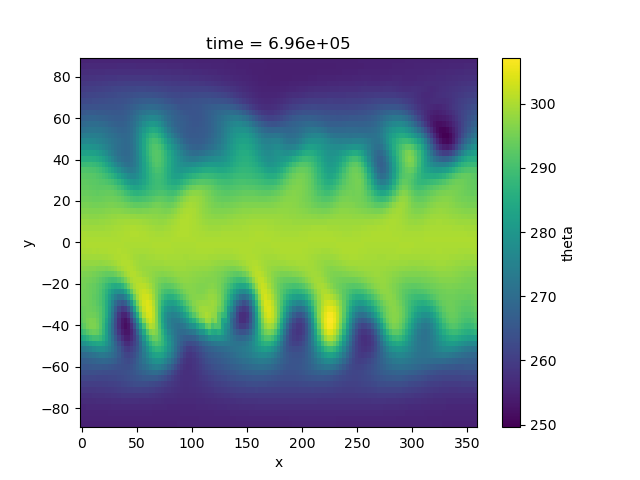

In [21]:
plt.figure()
climatology.isel(time=87).theta.plot()
plt.show()

<IPython.core.display.Javascript object>


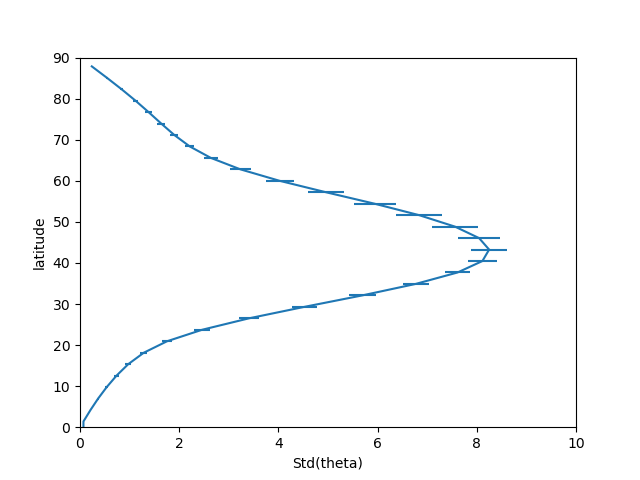

In [23]:
plt.figure()

plt.errorbar(y=climatology.y.values, x= climatology.theta.std('time').mean('x'),
             xerr=climatology.theta.std('time').std('x'), label = 'climatologyical spread')
plt.ylabel('latitude')
plt.xlabel('Std(theta)')
plt.xlim(0,10)
plt.ylim(0,90)
plt.show()

In [ ]:
climatology

In [5]:
climatology.to_netcdf('../climatology_linear.nc')

## 2.3 Check to see how long it takes for ensemble to approach climatology
Using our derived climatology from 2.2, and an ensemble of size 200, lets run a 6-week long simulation and see how our ensemble behaves.

In [ ]:
st = Sphere(base_state='solid')

params['ensemble_size']= 200
T=5*7*constants.day2sec
ensemble = em.integrate_ensemble(st=st,T=T,**params)

 44%|██████████████████▋                       | 89/200 [13:42<17:06,  9.25s/it]

In [6]:
climatology= climatology.std('time')

<IPython.core.display.Javascript object>


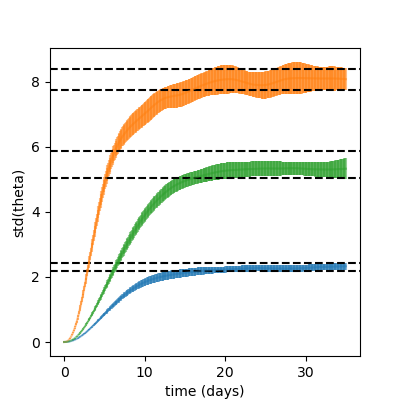

In [41]:
tidx=ensemble.time.size-1

s2d = 1/60./60./24.
fig = plt.figure(figsize=(4,4))
ys= [20,40,60]


for y in ys:
    plt.errorbar(ensemble.time*s2d, ensemble.theta.std('ens_mem').sel(y=y, method='nearest').mean('x'),
                 yerr= ensemble.theta.std('ens_mem').sel(y=y, method='nearest').std('x'), alpha=0.5)


    plt.axhline(climatology.theta.sel(y=y, method='nearest').mean(['x'])+climatology.theta.sel(y=y, method='nearest').std(['x']),
                0,1, color = 'k', linestyle = '--')
    plt.axhline(climatology.theta.sel(y=y, method='nearest').mean(['x'])-climatology.theta.sel(y=y, method='nearest').std(['x']),
                0,1, color = 'k', linestyle = '--')


plt.xlabel('time (days)')
plt.ylabel("std(theta)")

plt.show()


In [42]:
at_climo = np.empty(( len(ensemble.time), len(ensemble.y) ))

climate_ub = climatology.theta.mean(['x'])+climatology.theta.std(['x'])
climate_lb = climatology.theta.mean(['x'])-climatology.theta.std(['x'])

ensemble_spread_ub = ensemble.std('ens_mem').mean('x')+ensemble.std('ens_mem').std('x')
ensemble_spread_lb = ensemble.std('ens_mem').mean('x')-ensemble.std('ens_mem').std('x')

for t in range(len(ensemble.time)):
    at_climo[t,:] = (ensemble_spread_ub.theta.isel(time=t) > climate_lb)

<IPython.core.display.Javascript object>


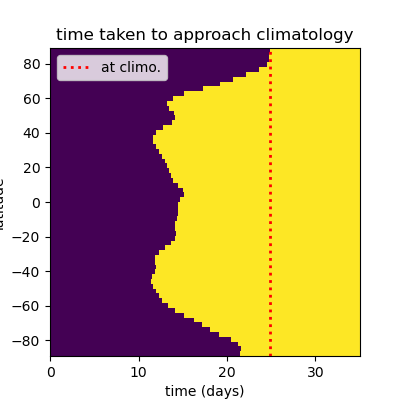

In [43]:
plt.figure(figsize=(4,4))
plt.pcolormesh(ensemble.time*s2d,ensemble.y,at_climo.T)
plt.axvline(ensemble.time[np.where(at_climo.sum(axis=-1) == at_climo.shape[-1])[0][0]]*s2d,
            label = 'at climo.', linestyle=':', color = 'r', lw=2)
plt.xlabel('time (days)')
plt.ylabel('latitude')
plt.title('time taken to approach climatology')
plt.legend()
plt.show()

In [44]:
ensemble.time[np.where(at_climo.sum(axis=-1) == at_climo.shape[-1])[0][0]]*s2d

<xarray.DataArray 'time' ()>
array(24.90740741)
Coordinates:
    time     float64 2.152e+06